# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
proj_name = "simulation_trajectory_overlap"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'May31-1408'

In [5]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [7]:
# Create an instance of the Simulation class

sim = ccd.ul.Simulation(n_cells=1000, n_genes=100, n_batches=2, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=10, 
                 state_min_level=0,
                 state_dispersion=2.0, 
                 program_structure='linear_bidirectional',
                 program_on_time_fraction=0.1,
                 trajectory_program_num=5,
                 trajectory_cell_block_size_ratio=0.6,
                 trajectory_loop_to=None,
                 batch_distribution = distribution,
                 batch_type=batch_type, 
                 batch_level=[10,10], 
                 batch_dispersion=[2.0, 2.0], 
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata_state = sim.simulate_state()
adata_state = adata_state[:, ccd.ul.sort_string_list(adata_state.var_names)]
adata_state.shape

(1000, 100)

In [8]:
# Define cell indices for each batch, with partial overlap
batch1_time = adata_state.obs['time'] < 600
batch2_time = adata_state.obs['time'] > 400
batch1_idx = np.where(batch1_time)[0]
batch2_idx = np.where(batch2_time)[0]

batch_indices = {0: batch1_idx, 1: batch2_idx}

In [9]:
from scipy import sparse as sp
import anndata as ad

batch_list = []
state_list = []
for i in range(sim.n_batches):
    batch_adata, batch_adata_pre = sim.simulate_batch(
        adata_state, 
        cell_proportion=sim.batch_cell_proportion[i], 
        cell_indices=batch_indices[i],
        batch_name=f"batch_{i+1}", effect_type=sim.batch_type[i], 
        distribution = sim.batch_distribution[i],
        level=sim.batch_level[i], dispersion=sim.batch_dispersion[i], 
        batch_feature_frac=sim.batch_feature_frac[i], seed=sim.seed+i)
    batch_list.append(batch_adata)
    state_list.append(batch_adata_pre)

adata = ad.concat(batch_list, join='outer')
adata.X = adata.X.toarray() if sp.issparse(adata.X) else adata.X
adata.X = np.nan_to_num(adata.X, nan=0.0)

adata = adata[:, ccd.ul.sort_string_list(adata.var_names)]

adata_pre = ad.concat(state_list, join='outer')
adata_pre = adata_pre[:, ccd.ul.sort_string_list(adata_pre.var_names)]

# Concatenate batch name to cell names to make them unique
adata.obs_names = [f"{batch}_{cell}" for batch, cell in zip(adata.obs['batch'], adata.obs_names)]
adata_pre.obs_names = [f"{batch}_{cell}" for batch, cell in zip(adata_pre.obs['batch'], adata_pre.obs_names)]

adata.obs['batch'] = adata.obs['batch'].astype('category')
adata_pre.obs['batch'] = adata_pre.obs['batch'].astype('category')

if sim.non_neg:
    adata.X[adata.X < 0] = 0
    adata_pre.X[adata_pre.X < 0] = 0
if sim.to_int:
    adata.X = adata.X.astype(int)
    adata_pre.X = adata_pre.X.astype(int)

adata.layers['wt_noise'] = adata.X 
adata_pre.layers['wt_noise'] = adata_pre.X
adata.layers['counts'] = adata.X.copy()

adata_state = adata_pre


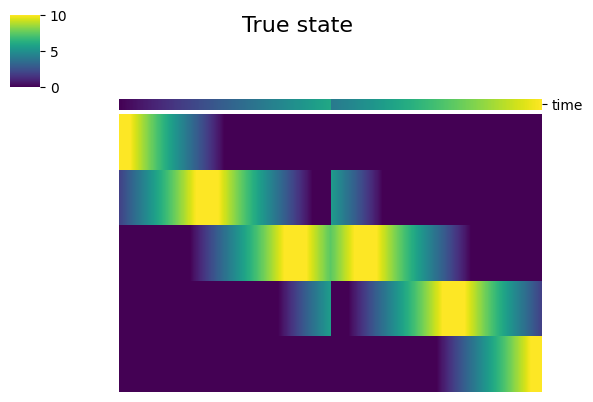

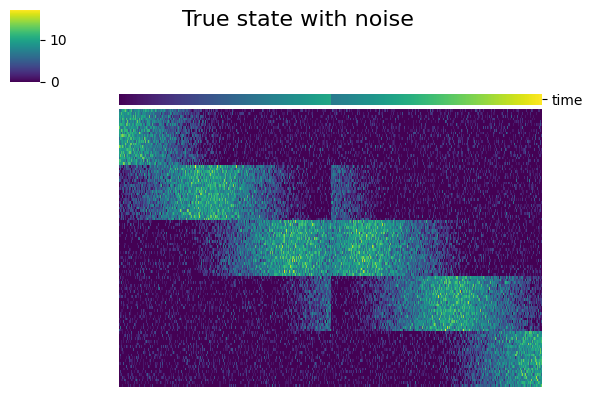

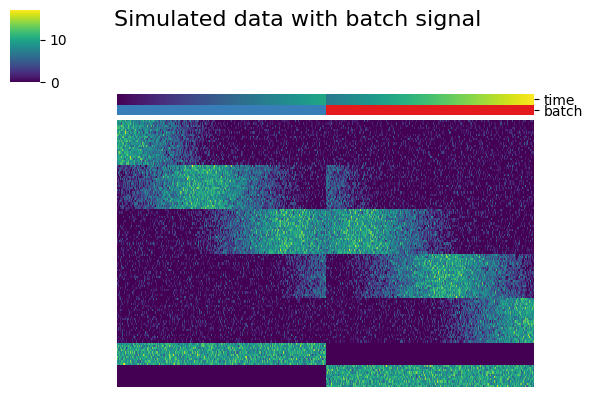

In [10]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### No batch effect, no noise

In [11]:
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_no_noise', result_key='UMAP_no_noise', random_state=seed)

Concord - INFO - PCA performed on source data with 30 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


In [12]:
sc.pp.neighbors(adata_state, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

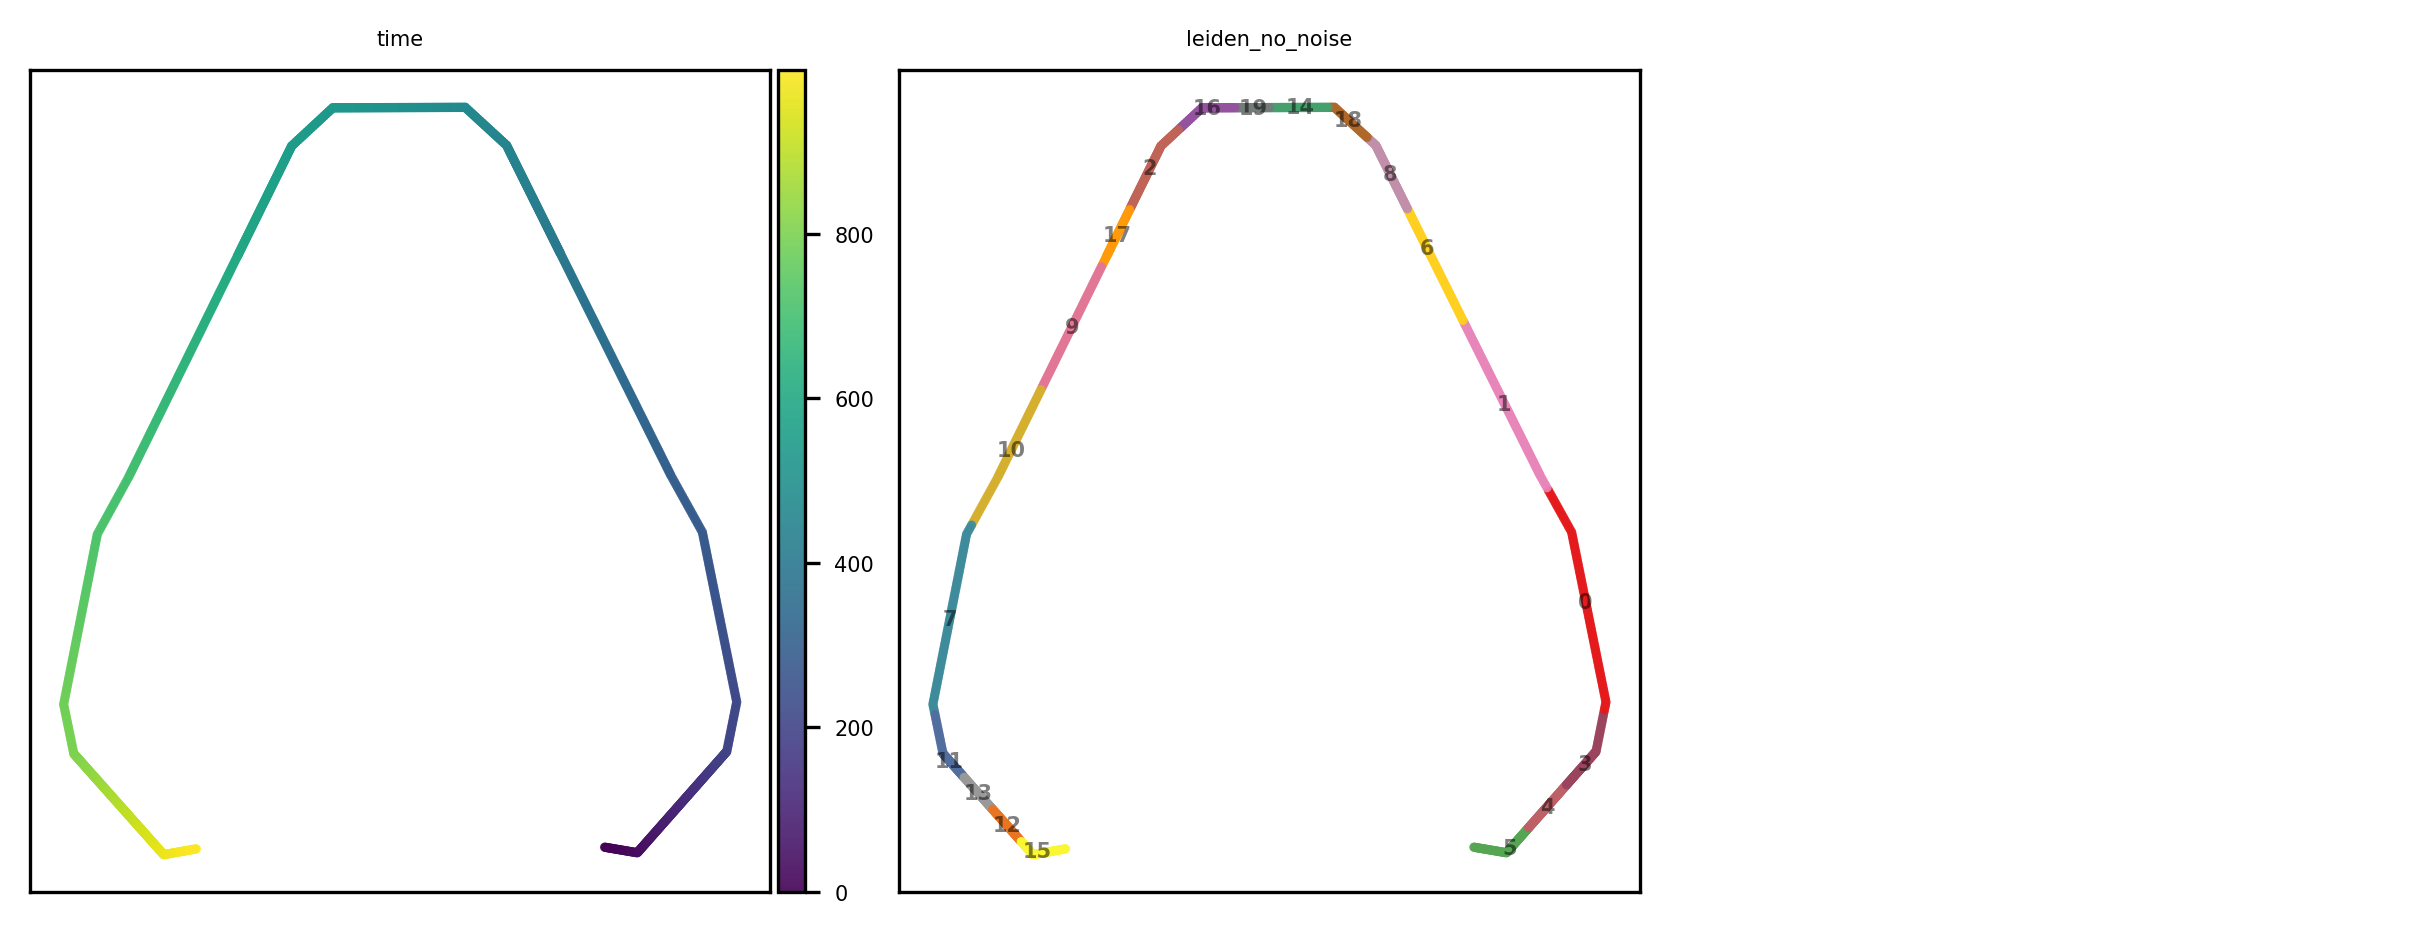

In [13]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

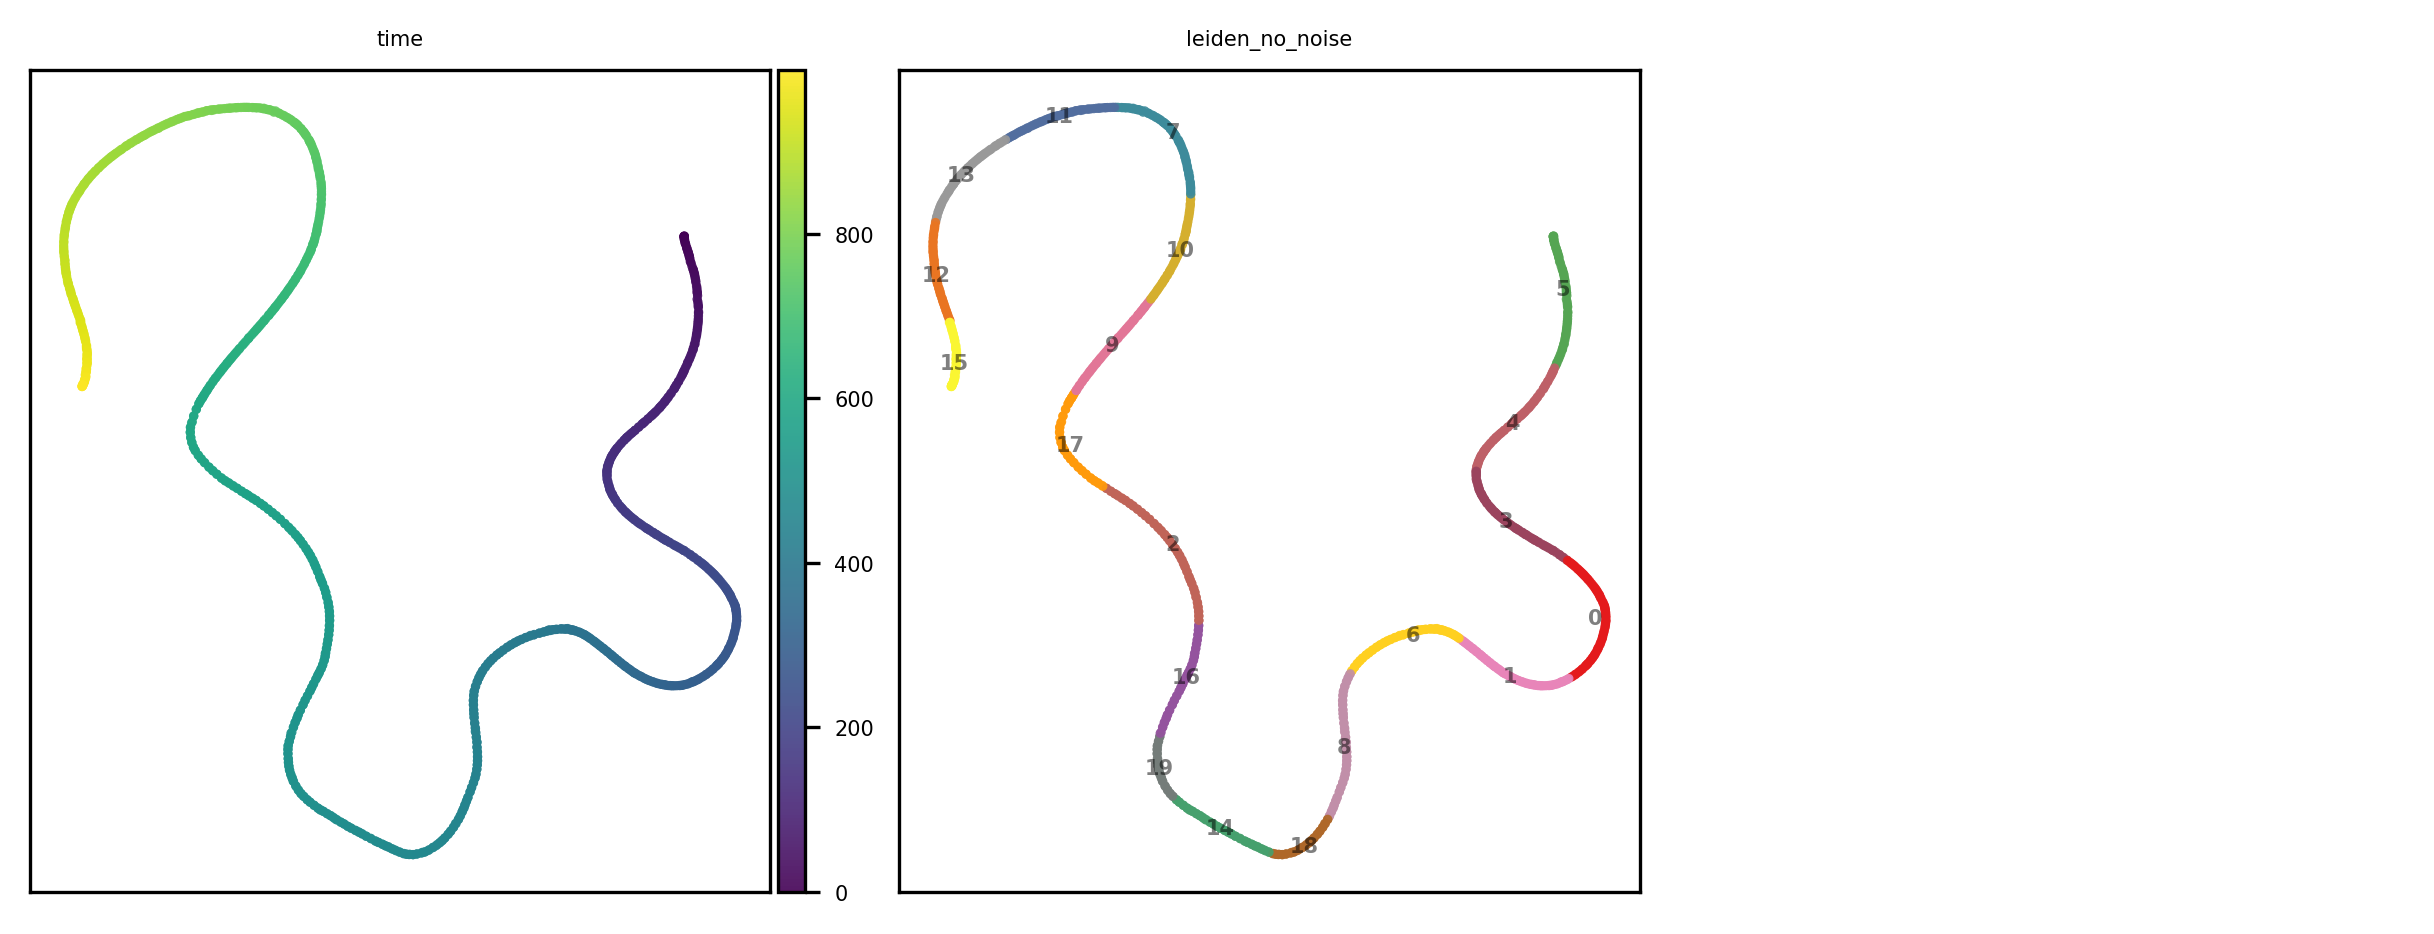

In [14]:
show_basis = 'UMAP_no_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### NO batch effect, noise added, PCA and UMAP

In [15]:
adata_state.X = adata_state.layers['wt_noise'].copy()
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_wt_noise', result_key='UMAP_wt_noise', random_state=seed)

Concord - INFO - PCA performed on source data with 30 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_wt_noise']
Concord - INFO - UMAP embedding stored in adata.obsm['UMAP_wt_noise']


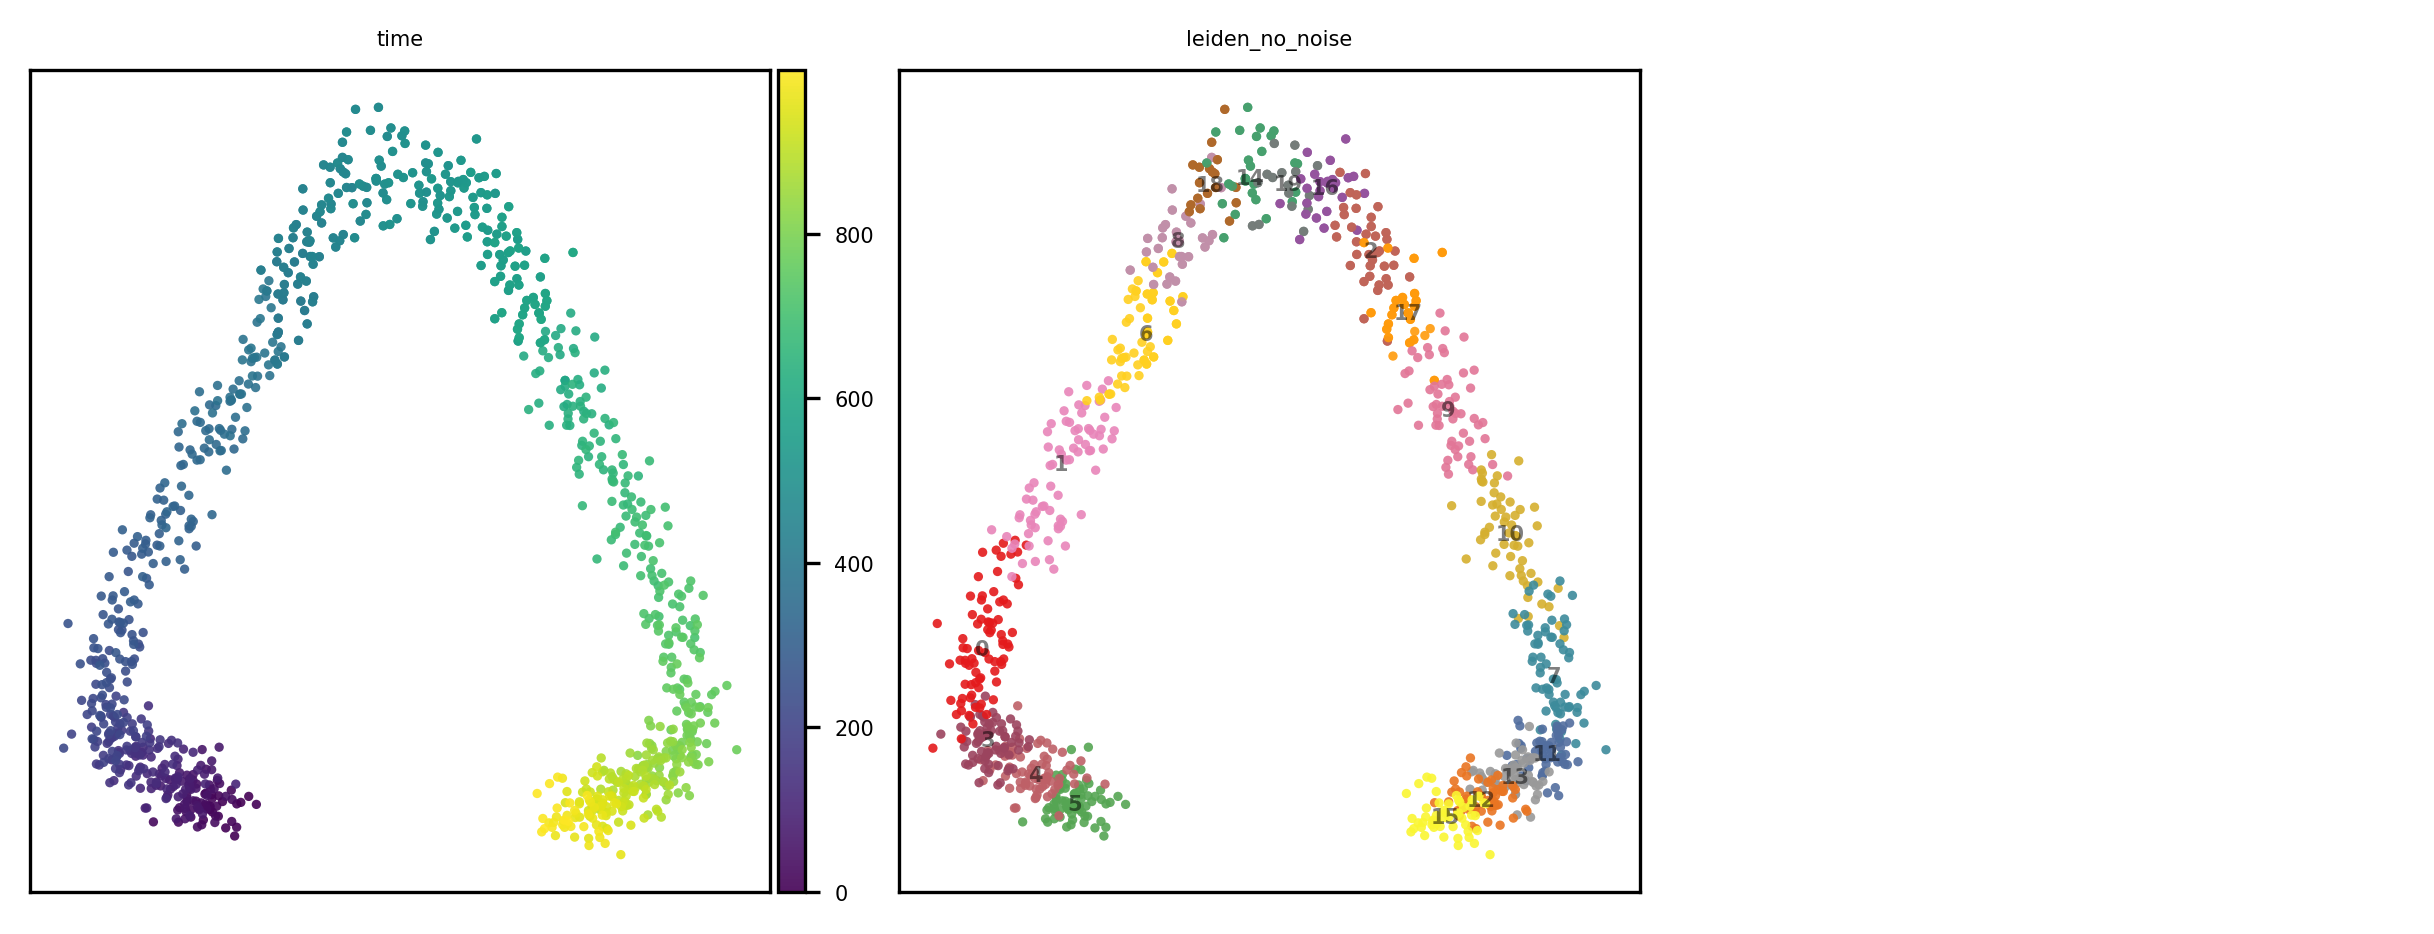

In [16]:
show_basis = 'PCA_wt_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

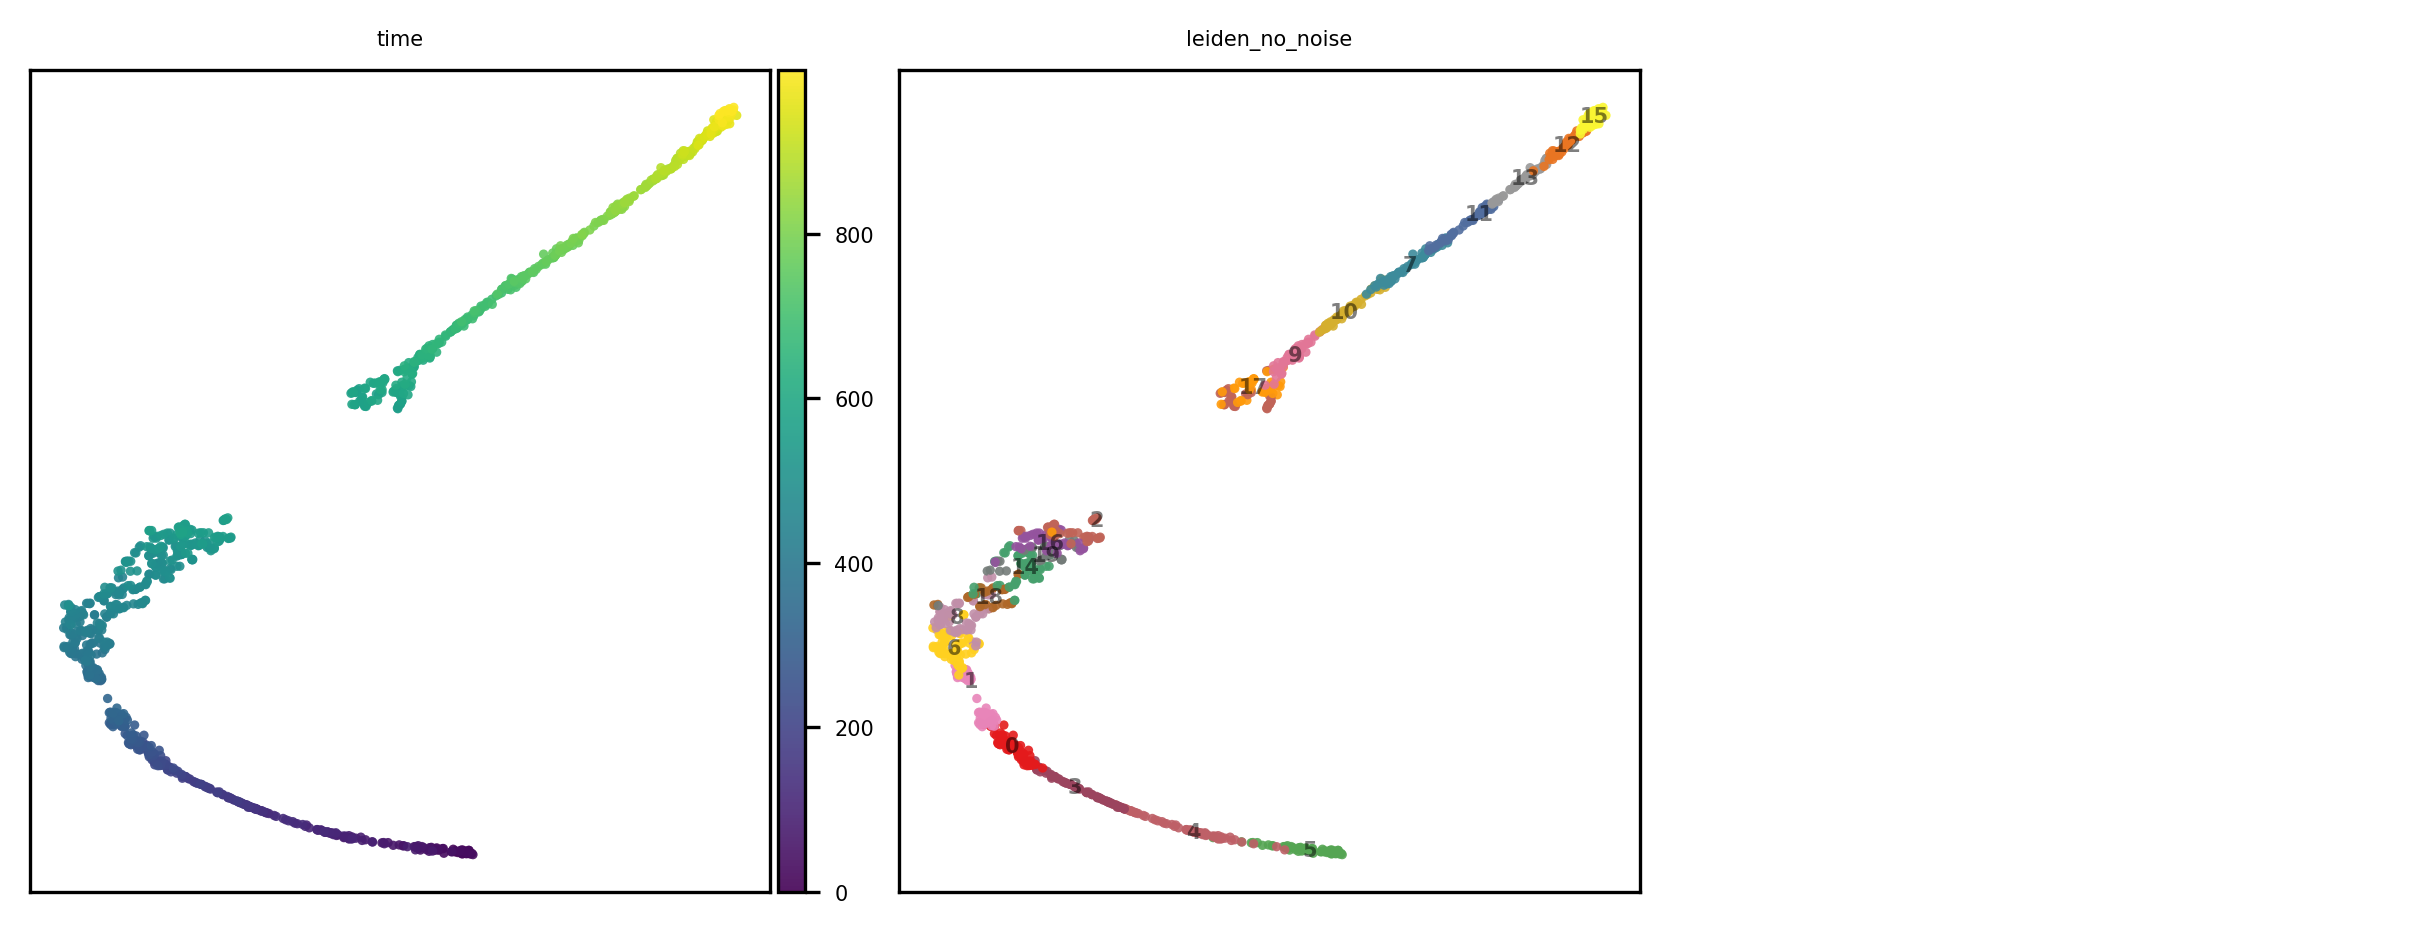

In [17]:
show_basis = 'UMAP_wt_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### No batch correction, PCA and UMAP

In [18]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.5)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

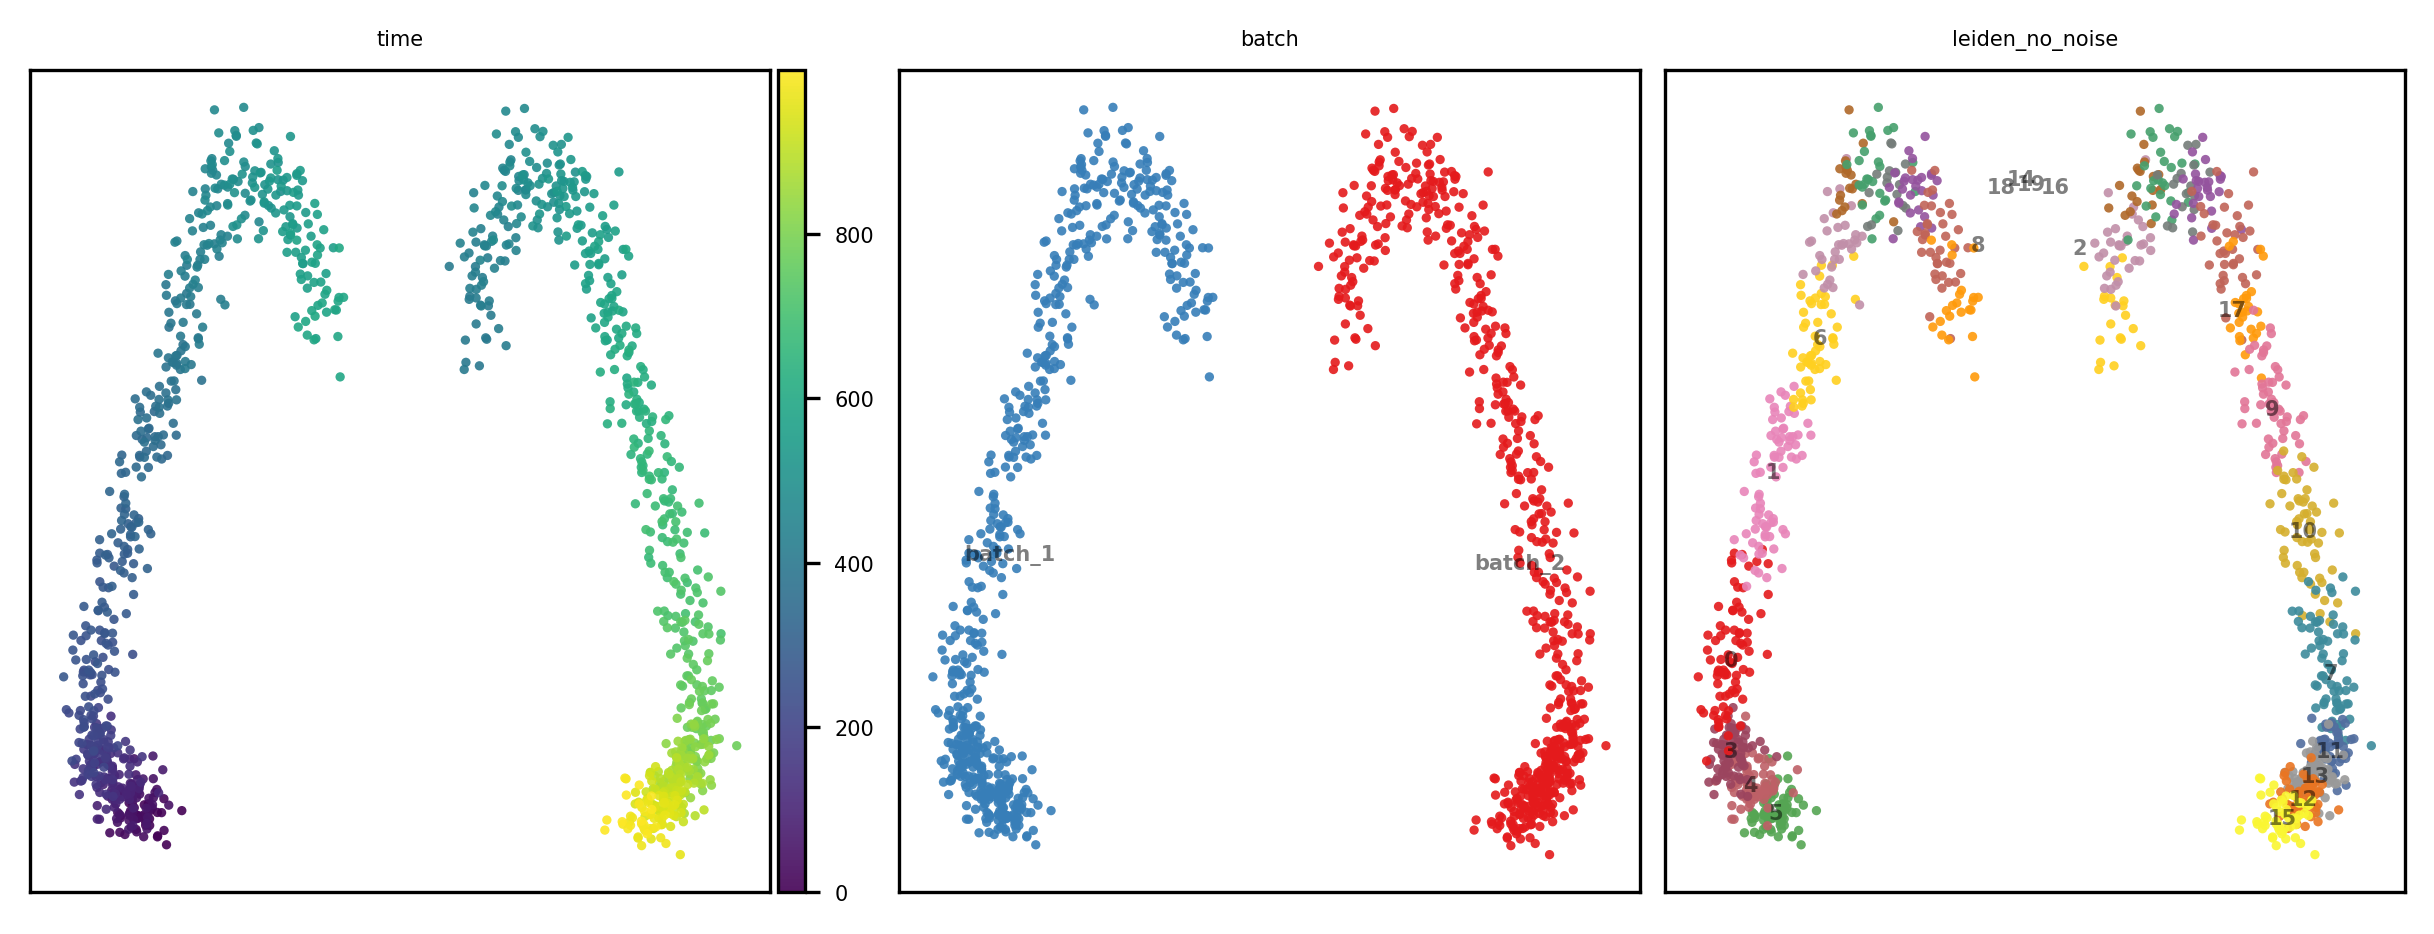

In [19]:
show_basis = 'X_pca'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

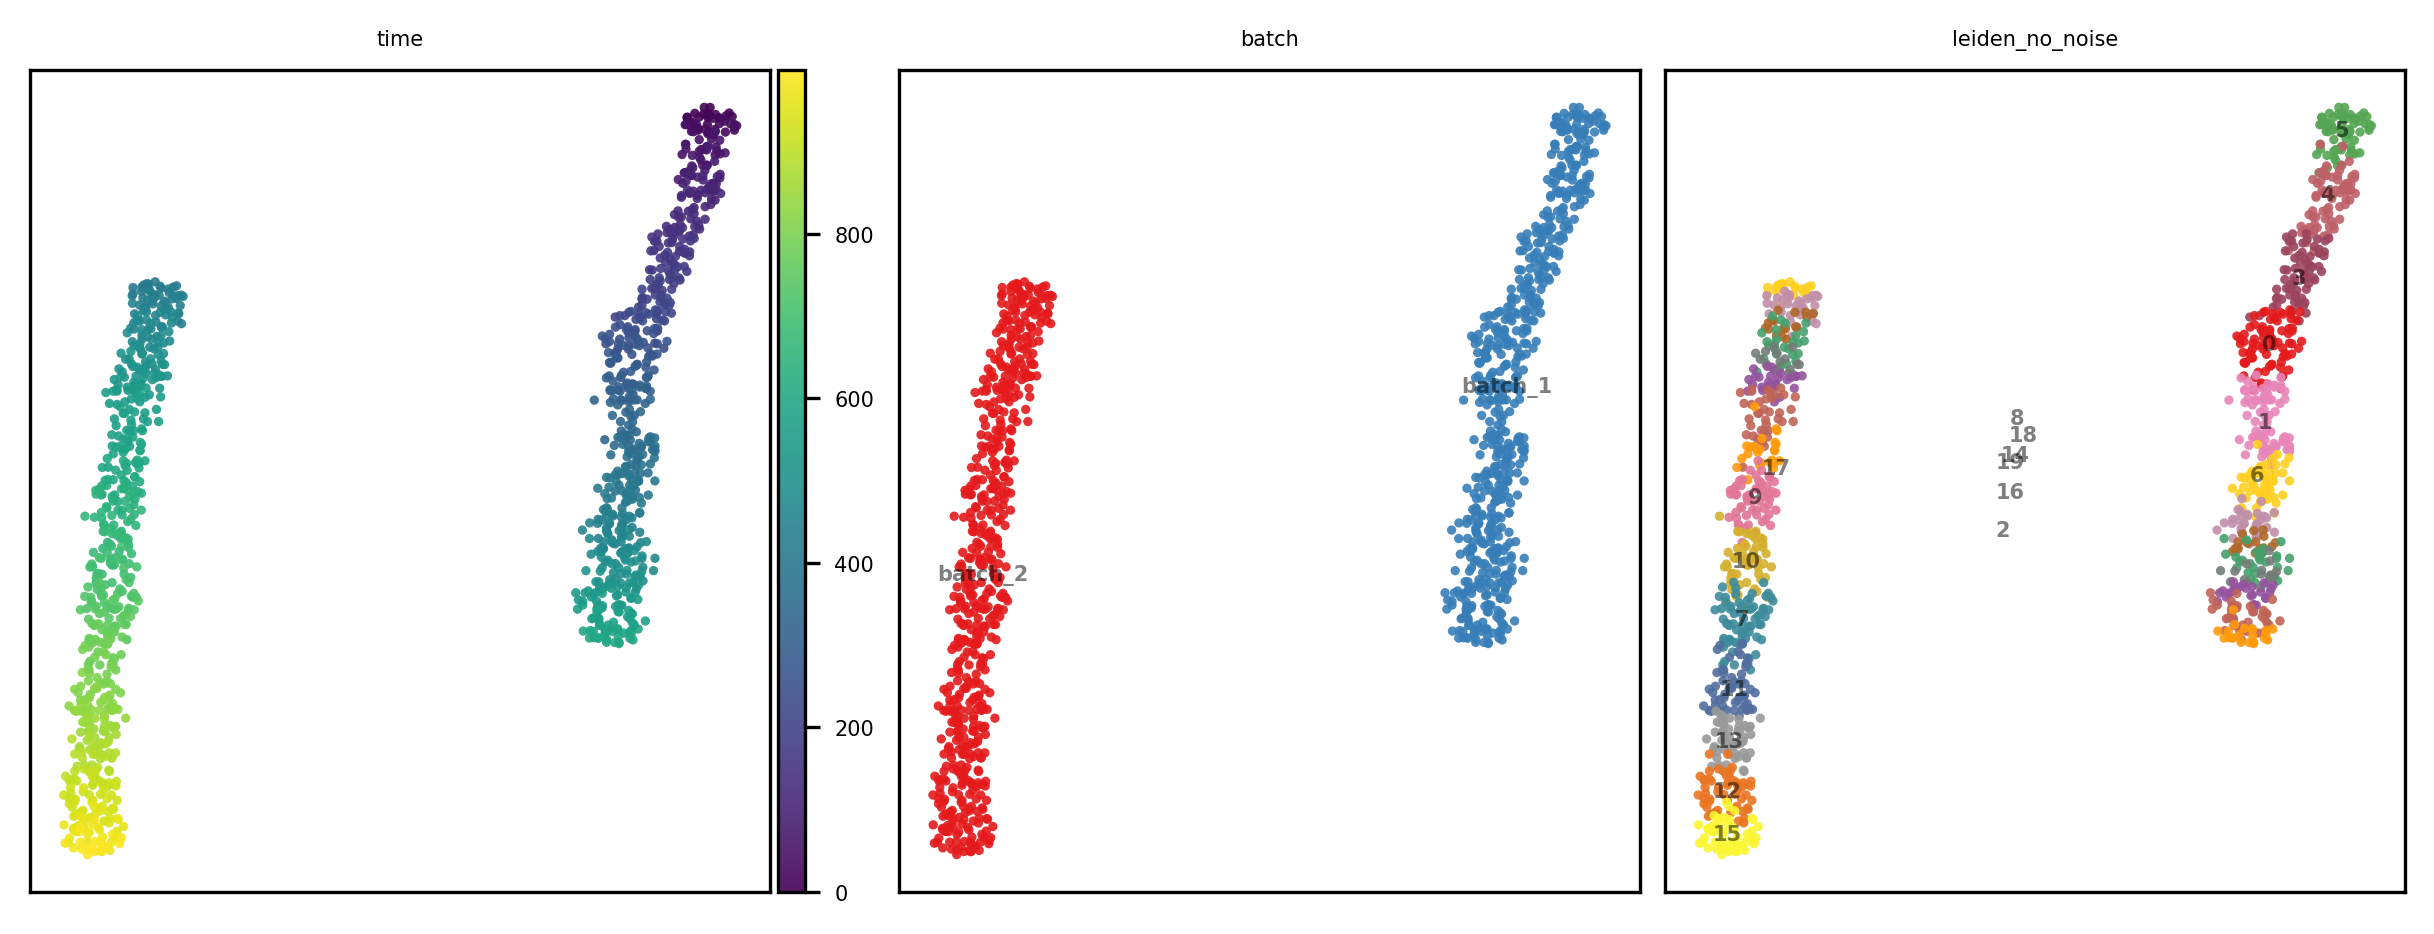

In [20]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

### Concord

In [35]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'

cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 18it [00:00, 186.72it/s, loss=4.08]
Epoch 9 Training: 100%|██████████| 18/18 [00:00<00:00, 244.74it/s, loss=3.77]


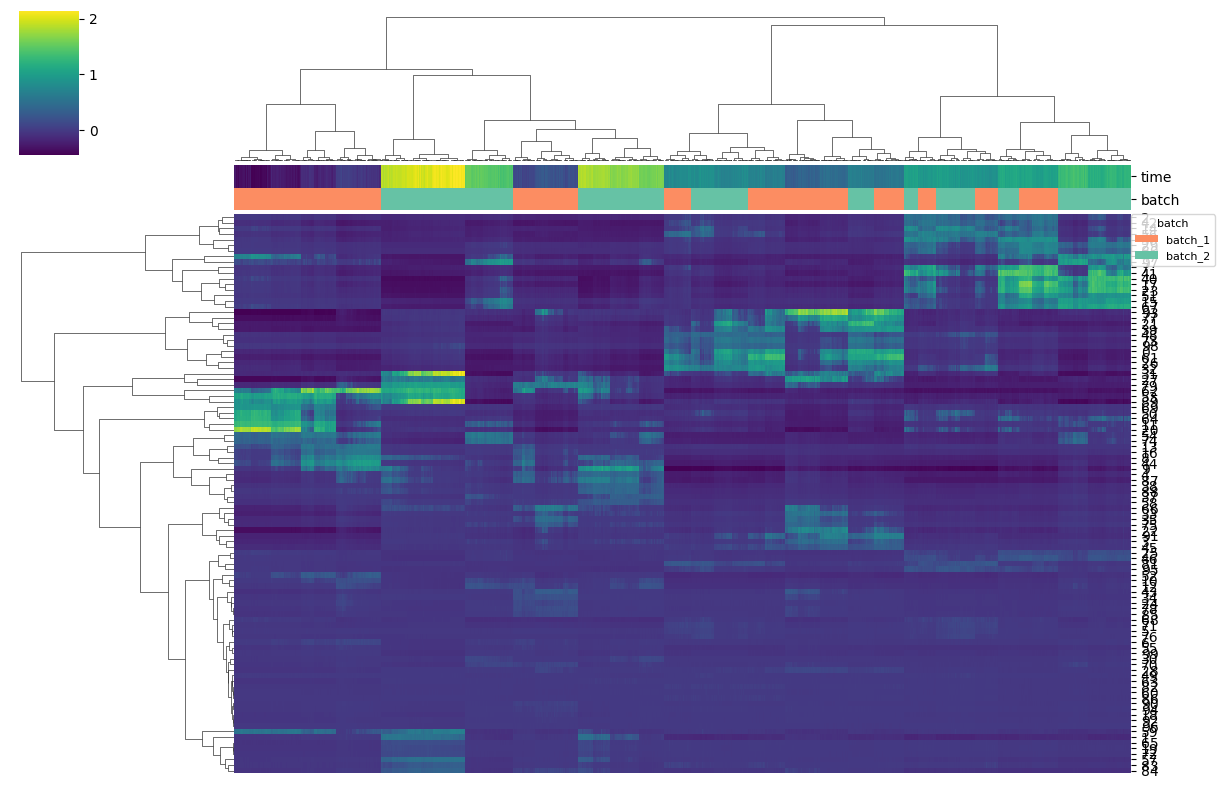

In [36]:
ccd.pl.heatmap_with_annotations(adata, val='Concord', obs_keys=[state_key, batch_key], 
                                cluster_cols=True, cluster_rows=True, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'Concord_latent_heatmap_{file_suffix}.png')

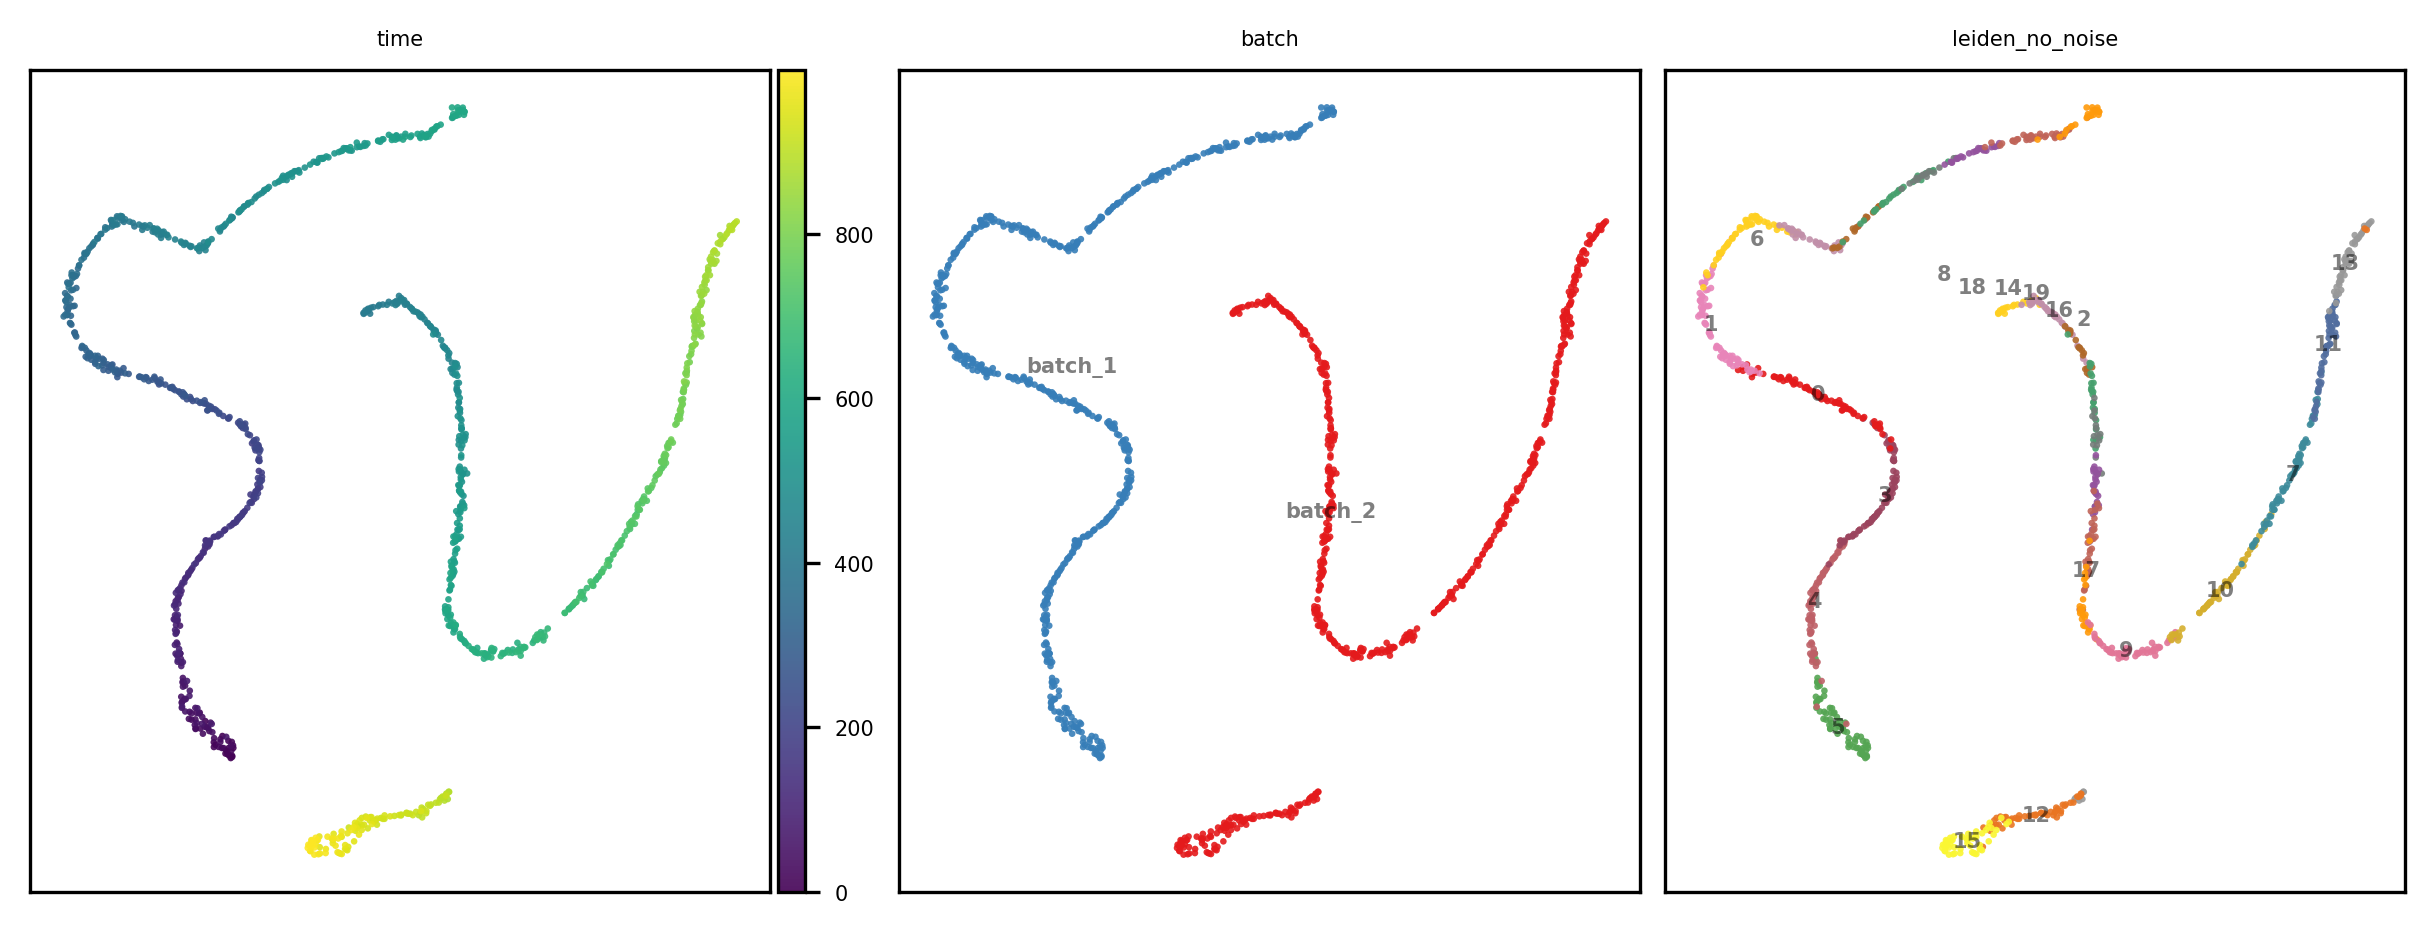

In [37]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep = 'Concord')
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key, leiden_key]
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


# Run other methods

In [38]:
file_suffix = f"{time.strftime('%b%d-%H%M')}"
ccd.set_verbose_mode(True)
show_cols = [state_key, batch_key]
timer = ccd.ul.Timer()
time_log = {}

### Scanorama

In [39]:
output_key = 'Scanorama'

with timer:
    ccd.ul.run_scanorama(adata, batch_key="batch", output_key=output_key, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

Found 120 genes among all datasets
[[0.         0.00166945]
 [0.         0.        ]]
Found 120 genes among all datasets
[[0.         0.00166945]
 [0.         0.        ]]


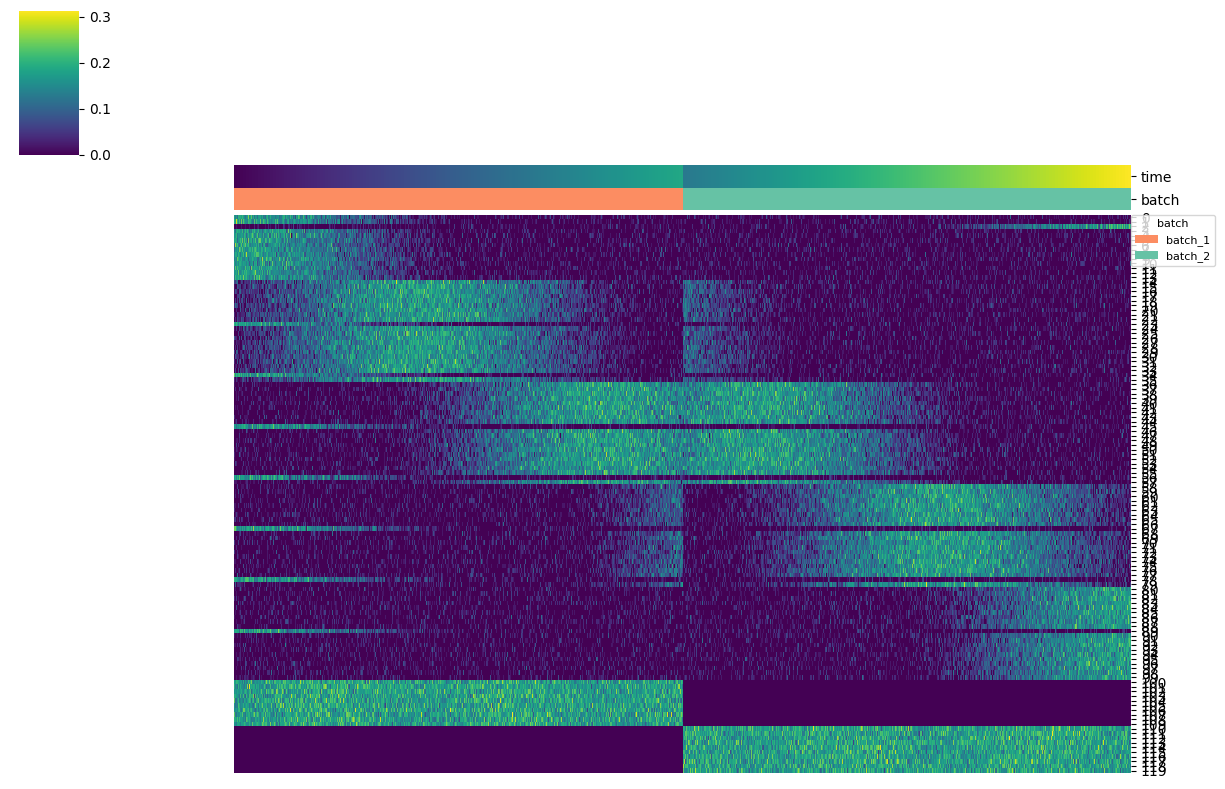

In [40]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_corrected_heatmap_{file_suffix}.png')

Concord - INFO - UMAP embedding stored in adata.obsm['Scanorama_UMAP']


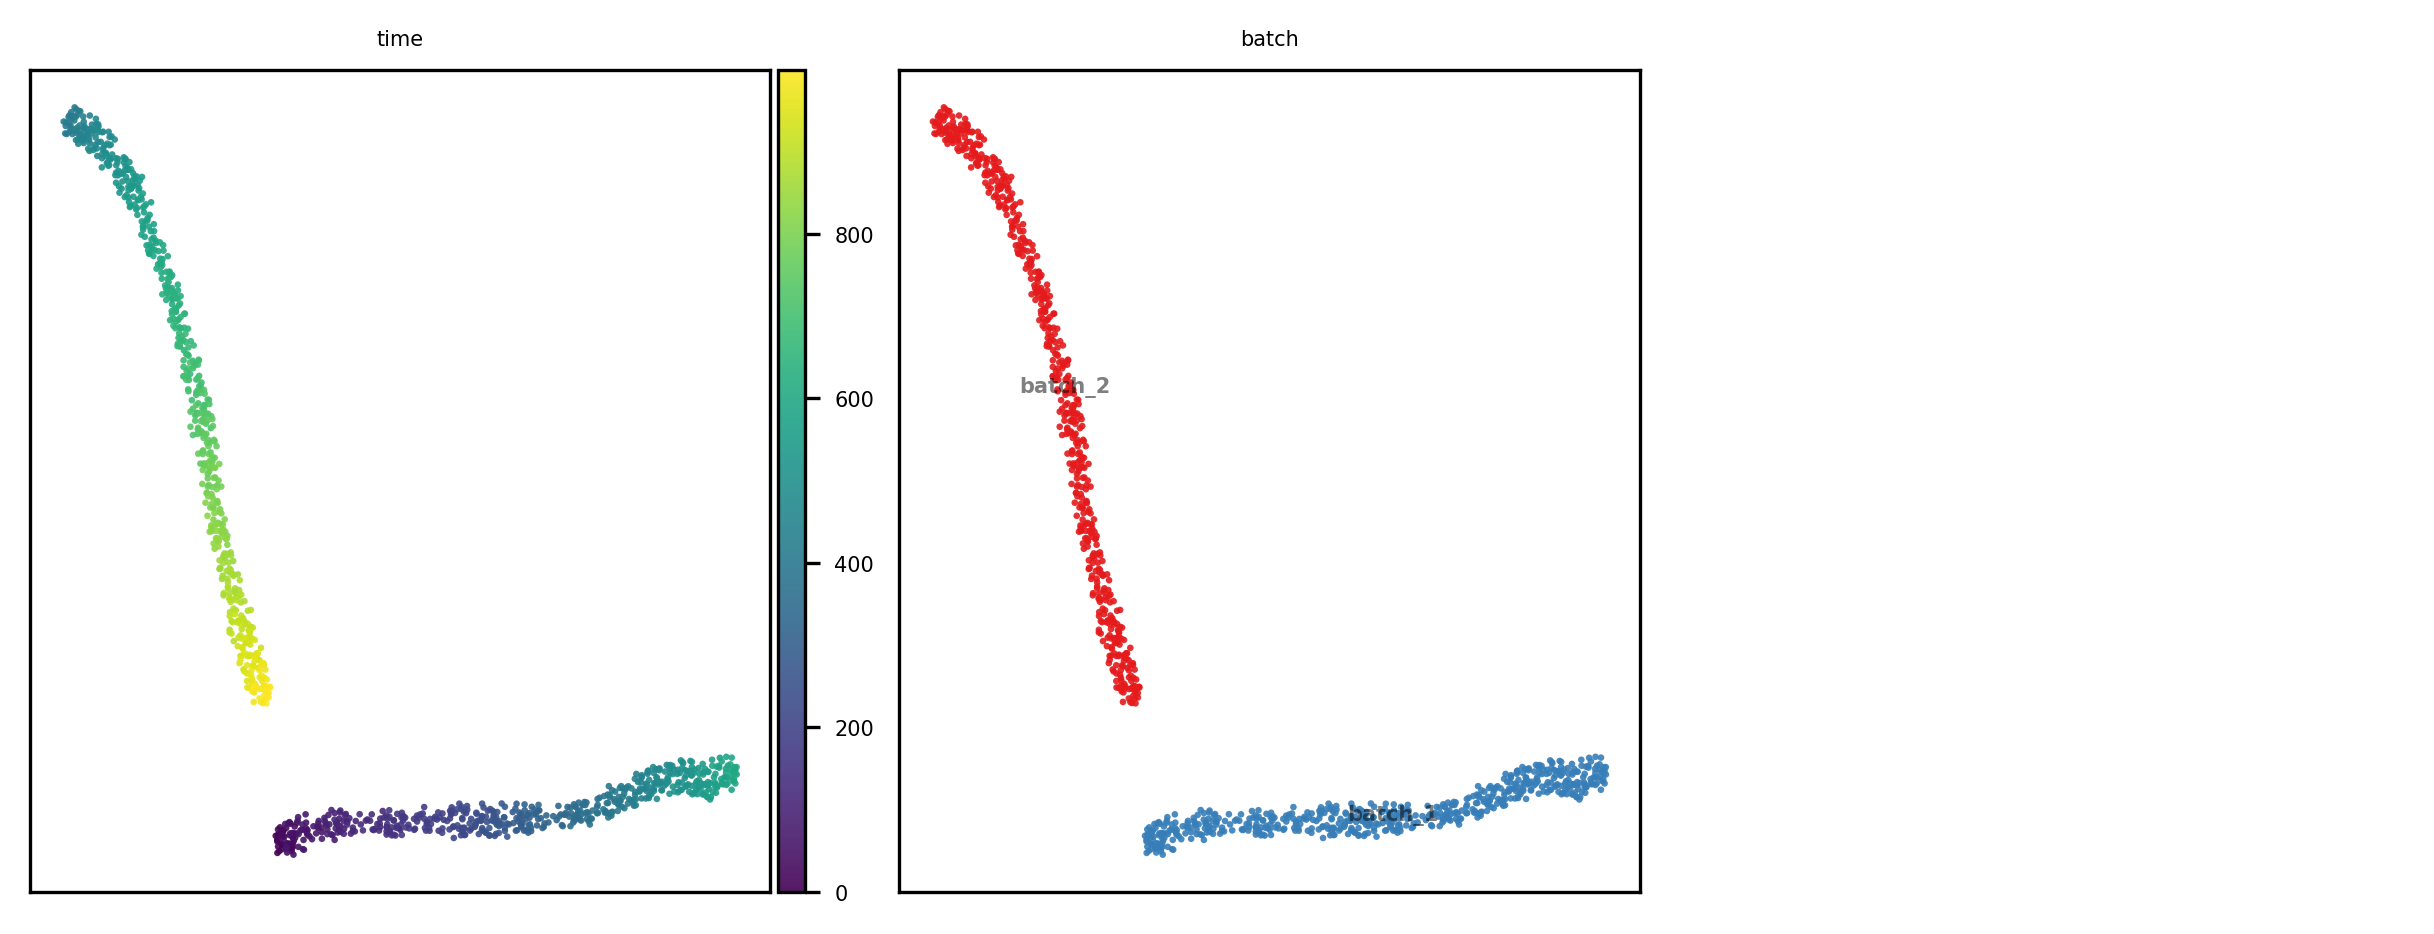

In [41]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Liger

In [42]:
output_key = 'Liger'
adata.layers["counts"] = adata.X.copy()
with timer:
    ccd.ul.run_liger(adata, batch_key="batch", count_layer="counts", output_key=output_key, k=30, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

100%|██████████| 30/30 [00:05<00:00,  5.95it/s]


In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Harmony

In [ ]:
output_key = 'Harmony'
with timer:
    ccd.ul.run_harmony(adata, batch_key="batch", input_key='X_pca', output_key=output_key)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### scVI

In [ ]:
output_key = 'scVI'
transform_batch = 'batch_1'
with timer:
    scvi_vae = ccd.ul.run_scvi(adata, batch_key="batch", output_key=output_key, return_model=True, return_corrected=True, transform_batch=transform_batch)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_corrected_heatmap_{file_suffix}.png')

In [ ]:
output_key = 'scVI'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### scANVI

In [ ]:
output_key = 'scANVI'
with timer:
    ccd.ul.run_scanvi(adata, batch_key="batch", labels_key=leiden_key, output_key=output_key, scvi_model=scvi_vae, return_corrected=True, transform_batch=transform_batch)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Concord

In [ ]:
min_p_intra_domain = 0.95

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      use_faiss=False,
                      min_p_intra_domain=min_p_intra_domain,
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
with timer:
    cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False, return_latent=True)
    
time_log[output_key] = timer.interval

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
ccd.pl.plot_graph(adata, basis=output_key, color_by = show_cols, edges=True, k=15, ncols=2, figsize=(8,3), dpi=100)

### Concord with decoder

In [ ]:
decoder_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      class_key=leiden_key, # key indicating class
                      use_classifier=False, # use classifier
                      use_decoder=True,
                      domain_embedding_dim=8,
                      min_p_intra_domain=min_p_intra_domain,
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

output_key = 'Concord-decoder'
with timer:
    decoder_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(decoder_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")


In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
# Predict and store the results
decoder_domains = adata.obs[batch_key].unique()
for domain in decoder_domains:
    _, decoded, _, _, _, _ = decoder_ccd.predict(decoder_ccd.loader, return_decoded=True, decoder_domain=domain, return_class=True, return_class_prob=True)
    save_key = f"{output_key}_decoded_{domain}"
    adata.layers[save_key] = decoded

adata.layers

### Concord with classifier

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      min_p_intra_domain=min_p_intra_domain,
                      domain_key=batch_key, # key indicating batch
                      class_key=leiden_key, # key indicating class
                      use_classifier=True, # use classifier
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-class'
with timer:
    cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Contrastive without specifying domain

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=None, # key indicating batch
                      min_p_intra_domain=None, # probability of sampling intra-domain pairs
                      seed=seed, # random seed
                      verbose=True, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Contrastive'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)


In [ ]:
adata.obsm['Unintegrated'] = adata.obsm['X_pca']
n_pc=30
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_pc, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=n_pc, random_state=seed)

# Put the PCA result in the adata object, so only one object is needed
adata.obsm['PCA_no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm['PCA_wt_noise'] = adata_state.obsm['PCA_wt_noise']
adata.obsm

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI","Concord_nd", "Concord", 'Concord-decoder', "Concord-class",  "scANVI"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 


In [ ]:


# Run umap and PCA for all latent embeddings
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    if basis not in adata.obsm:
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


In [ ]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd


# from matplotlib import font_manager, rcParams

# # Add custom font path
# font_dirs = ['/wynton/home/gartner/zhuqin/.conda/envs/cellpath/fonts']  # Your custom fonts directory
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

# # Create FontProperties for each custom font and add to the font manager
# for font_path in font_files:
#     font_manager.fontManager.addfont(font_path)

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['time', 'batch']
#basis_types = ['KNN', 'UMAP']
basis_types = ['PCA']
#basis_types = ['KNN']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = int(np.ceil(len(combined_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0.0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = False
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [ ]:
adata.layers['no_noise'] = np.zeros_like(adata.X)
adata.layers['wt_noise'] = np.zeros_like(adata.X)
# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()
adata.layers['wt_noise'][:, adata_indices] = adata_state.layers['wt_noise'][:, adata_state_indices].copy()

# sort and smooth the signal along the path
#batch_id=adata.obs['batch'].unique()[0]
cell_order = adata.obs['time'].argsort()
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=cell_order, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=cell_order, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

In [ ]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [ ]:
adata_time_sorted = adata[cell_order]
ccd.pl.heatmap_with_annotations(adata_time_sorted, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=True, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)

In [ ]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

# Evaluation

In [ ]:
adata = sc.read(data_dir / f"adata_Nov24-1414.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Nov24-1414.h5ad")
# adata = sc.read(data_dir/f"adata_Nov25-1433.h5ad")
# adata_state = sc.read(data_dir/f"adata_state_Nov25-1433.h5ad")

### Scib

In [ ]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=leiden_key,
    embedding_obsm_keys=latent_keys,
    n_jobs=6,
)
bm.benchmark()

In [ ]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

In [ ]:
import pandas as pd
scib_scores = bm.get_results(min_max_scale=False)
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.ul.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

ccd.pl.plot_benchmark_table(scib_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 6), dpi=300)

### Topology

Run topological analysis pipeline:

In [ ]:
homology_dimensions = [0,1,2]
concord_keys = ['Concord', 'Concord-decoder', 'Concord-class']
#diagrams = {}
#for key in combined_keys:
for key in concord_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

In [ ]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

In [ ]:
# import pickle
# with open(Path('../save/dev_simulation_trajectory_overlap-Nov16') / f"topology_diagrams_Nov16-1343.pkl", 'rb') as f:
#     diagrams = pickle.load(f)
import pickle'../save/dev_simulation_trajectory_overlap-Nov24') / f"topology_diagrams_Nov24-2026.pkl"
with open(Path(, 'rb') as f:
    diagrams = pickle.load(f)

In [ ]:
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=[0,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics'].drop(index=['PCA_no_noise', 'PCA_wt_noise'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.ul.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 6), dpi=300)

In [ ]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('PCA_', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=11, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=11, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

In [ ]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'PCA_no_noise','(wn)': 'PCA_wt_noise'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=30)
agg_name1 = 'Connectivity'
agg_name2 = 'Score'
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df, min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(8, 8), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "scANVI", "Concord", 'Concord-decoder', "Concord-class"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 

In [ ]:
geometry_metrics = ['pseudotime', 'cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr', 'state_batch_distance_ratio']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'PCA_wt_noise'
groundtruth_key = 'PCA_no_noise'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      state_key = leiden_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

In [ ]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df.drop(index=['PCA_no_noise', 'PCA_wt_noise']), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 7), dpi=300)

In [ ]:
geometry_full['Pseudotime']['pseudotime'].keys()

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['Pseudotime']['pseudotime'], 
    correlation= geometry_full['Pseudotime']['correlation'],
    s=3,
    ground_key = 'time', fontsize=9,
    n_cols = 11, figsize=(1.7,2.1), dpi=300, save_path=save_dir / f"pseudotime_scatter_{groundtruth_key}_{file_suffix}.pdf")

In [ ]:
import matplotlib.pyplot as plt

n_cols = 11
n_rows = int(np.ceil(len(combined_keys) / n_cols))
base_size = (1.5, 1.7)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*base_size[0], n_rows*base_size[1]), dpi=300)

axes = np.atleast_2d(axes).flatten()
for basis in combined_keys:
    show_basis = basis + '_UMAP'
    if show_basis not in adata.obsm or basis not in geometry_full['Pseudotime']['pseudotime']:
        show_indices = None
        adata.obs['pseudotime_plot'] = np.nan
    else:
        show_indices = geometry_full['Pseudotime']['path'][basis]
        adata.obs['pseudotime_plot'] = geometry_full['Pseudotime']['pseudotime'][basis]
    
    show_cols = ['pseudotime_plot']

    ccd.pl.plot_embedding(
        adata, show_basis, show_cols, highlight_indices=show_indices, highlight_size=5, draw_path=True, alpha=1.0,
        font_size=12, point_size=10, path_width=1,
        legend_loc='on data', title=basis, colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None, 
        ax=axes[combined_keys.index(basis)]
    )

plt.tight_layout()
plt.savefig(save_dir / f"pseudotime_embedding_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 11, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['cell_distance_corr']['distance'], 
    correlation= geometry_full['cell_distance_corr']['correlation'],
    s=0.1, alpha = 0.2,
    n_cols = 3, figsize=(2,2), dpi=300, save_path=save_dir / f"cell_distance_scatter_{file_suffix}.png")

In [ ]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(4,3))

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_distance_corr']['distance'], 
    correlation= geometry_full['state_distance_corr']['correlation'],
    n_cols = 3, figsize=(2,2), dpi=300, save_path=save_dir / f"state_distance_scatter_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_dispersion_corr']['dispersion'], 
    correlation= geometry_full['state_dispersion_corr']['correlation'],
    s=10,
    ground_key = 'PCA_wt_noise',
    n_cols = 3, figsize=(2,2), dpi=300, save_path=save_dir / f"state_distance_scatter_{file_suffix}.pdf")

In [ ]:
plot_df = geometry_full['state_batch_distance_ratio'].drop(index=['PCA_no_noise', 'PCA_wt_noise'])
ccd.pl.plot_bar(plot_df, 'State-Batch Distance Ratio (log10)', save_path=save_dir / f"state_batch_distance_ratio_{groundtruth_key}_{dist_metric}_{file_suffix}.pdf", figsize=(3,2), dpi=300)

### 2.0 Decoder reconstruction

In [ ]:
adata.layers

In [ ]:
# Align and copy the layer data based on observation names
adata.layers['no_noise'] = np.zeros_like(adata.X)

# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()

decoded_layers = ['Concord-decoder_decoded_batch_1', 'Concord-decoder_decoded_batch_2']
show_layers = ['no_noise', 'wt_noise'] + decoded_layers
ccd.pl.plot_adata_layer_heatmaps(adata, ncells=None, ngenes=None, layers=show_layers, cmap='viridis', vmin=0, vmax=7, 
                                 obs_keys=[state_key, batch_key], transpose=False, figsize=(6,6),  dpi=300, save_path=save_dir/f'decoded_heatmap_{file_suffix}.png')

In [ ]:
# Compute the reconstruction error between the original and reconstructed data
mse_no_noise = np.zeros(len(decoded_layers))
mse_wt_noise = np.zeros(len(decoded_layers))
state_genes = adata.var_names[adata.var_names.isin(adata_state.var_names)]
for layer in decoded_layers:
    mse_no_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'no_noise', layer, metric='mse')
    mse_wt_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'wt_noise', layer, metric='mse')

# Report value, mean
print(f"MSE between no_noise and decoded layers: {mse_no_noise}")
print(f"MSE between wt_noise and decoded layers: {mse_wt_noise}")
print(f"Mean MSE between no_noise and decoded layers: {np.mean(mse_no_noise):.4f}")
print(f"Mean MSE between wt_noise and decoded layers: {np.mean(mse_wt_noise):.4f}")
